In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
import csv
import sys
import numpy as np
import time
import copy
import torch.nn.init

gpu_num = 1

In [2]:
device = ('cuda'+':'+ str(gpu_num)) if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == ('cuda'+ ':' + str(gpu_num)) :
    torch.cuda.manual_seed_all(777)

In [3]:
learning_rate   = 0.0001
training_epochs = 30
batchsize       = {'min':0,'max':0}
batchprocess    = {'totalsize':8000, 'chunksize':200, 'chunkcount':0}
totalBatch      = np.uint16(batchprocess['totalsize']/batchprocess['chunksize']) 

In [4]:
count = 0
filename ='/home/fdcl/Music/Molcom/landingdat/2nd/dat/vis_dat_cmd.csv'

Xmatrix = np.zeros([batchprocess['chunksize'],76800], dtype=np.float32)
Ymatrix = np.zeros([batchprocess['chunksize'],4], dtype=np.float32)

csv.field_size_limit(230404)

131072

In [5]:
def readercommand(cmd):

    global filename
    global Reader
    global f
    if cmd == 'open':
        f = open(filename,'r')
        Reader = csv.reader(f)#, delimiter=' ')
    elif cmd == 'close':
        f.close()
        print('closed')
    else:
        print('error')

def getbatch(batchcount):
    global count
    smallcount = 0
    batchsize['min'] =  batchcount      *   batchprocess['chunksize']
    batchsize['max'] = (batchcount+1)   *   batchprocess['chunksize']
    #batchprocess['chunkcount'] = batchprocess['chunkcount'] + 1

    Xmatrix = np.zeros([batchprocess['chunksize'],76800], dtype=np.float32)
    Ymatrix = np.zeros([batchprocess['chunksize'],4], dtype=np.float32)
    del Xmatrix, Ymatrix
    Xmatrix = np.zeros([batchprocess['chunksize'],76800], dtype=np.float32)
    Ymatrix = np.zeros([batchprocess['chunksize'],4], dtype=np.float32)
    
    for row in Reader:
        if (count >= batchsize['min']) & (count < batchsize['max']):
            Xmatrix[smallcount, 0:76800]  = row[0:76800]
            Ymatrix[smallcount, 0:4]       = row[230400:230404]
            smallcount = smallcount+1
        elif count >= batchsize['max']:
            break
        count = count+1
        #print(count,'slice done',batchcount)
    
    Xmatrix = Xmatrix.reshape([batchprocess['chunksize'],1,240,320])
    

    return torch.from_numpy(Xmatrix), torch.from_numpy(Ymatrix)

#readercommand('open')

In [6]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
                      nn.Conv2d(1,3,kernel_size=3, stride=1, padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
                      nn.Conv2d(3,27,kernel_size=3, stride=1, padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(2)
        )
        
        self.layer3 = nn.Sequential(
                      nn.Conv2d(27,81,kernel_size=3, stride=1, padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(2)
        )
        
        self.layer4 = nn.Sequential(
                      nn.Conv2d(81,243,kernel_size=3, stride=1, padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(2)
        )
        
        self.layer5 = nn.Sequential(
                      nn.Conv2d(243,729,kernel_size=3, stride=1, padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(2)
        )
        
        self.layer6 = nn.Sequential(
                      nn.Conv2d(729,2187,kernel_size=3, stride=1, padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(2)
        )
        
        
        print
        self.fc1     = nn.Linear(15*2187, 648, bias = True)    
        self.relu1   = nn.ReLU()
        self.fc2     = nn.Linear(648, 216, bias = True) 
        self.relu2   = nn.ReLU()
        self.fc3     = nn.Linear(216, 108, bias = True)
        self.relu3   = nn.ReLU()
        self.fc4     = nn.Linear(108, 27, bias = True)
        self.relu4   = nn.ReLU()
        self.fc5     = nn.Linear(27, 4, bias = True)

        self.fc6     = nn.Linear(4, 4, bias = True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        torch.nn.init.xavier_uniform_(self.fc5.weight)
        torch.nn.init.xavier_uniform_(self.fc6.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)      
        out = self.layer5(out)  
        out = self.layer6(out)  
        
        out = out.view(out.size(0), -1)
        print(out.shape)
        out = self.fc1(out)
        out = self.relu1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)
        out = self.relu3(out)
        
        out = self.fc4(out)
        out = self.relu4(out)
        
        out = self.fc5(out)
   
        out = self.fc6(out)
        return out

In [7]:
model = CNN().to(device)


In [8]:
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(3, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(27, 81, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(81, 243, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(243, 729, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [9]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

Learning Started. It takes some time
batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size

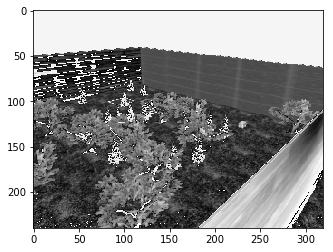

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

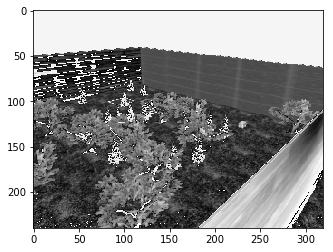

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

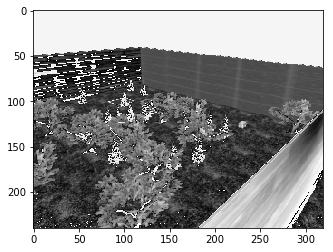

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

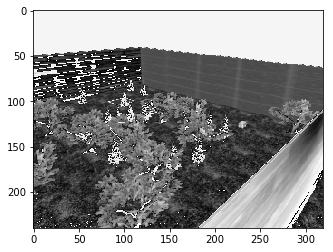

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

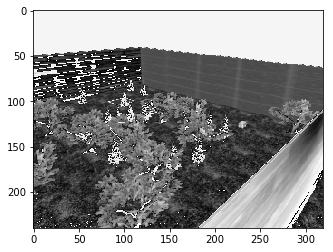

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

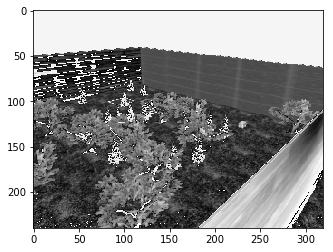

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

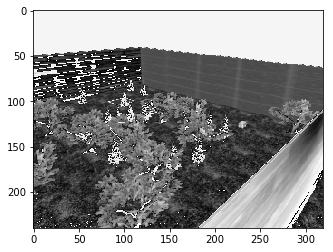

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

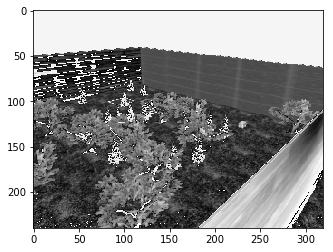

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

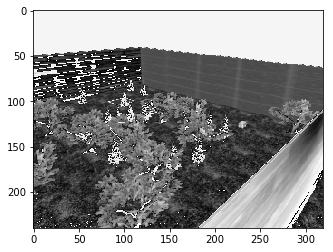

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

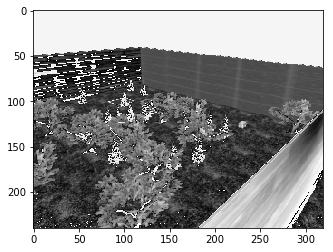

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

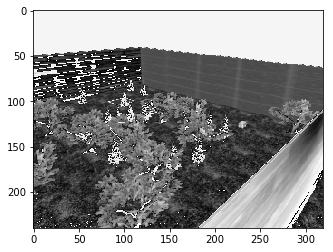

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

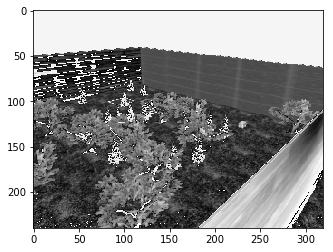

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

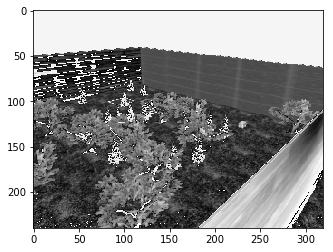

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

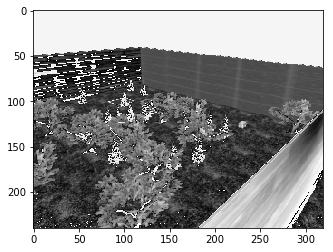

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

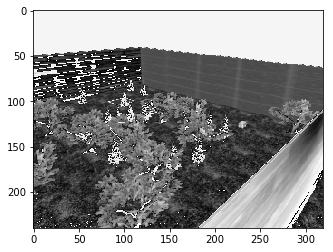

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

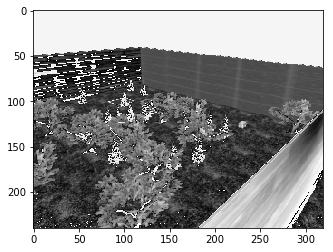

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

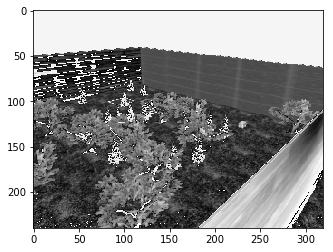

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

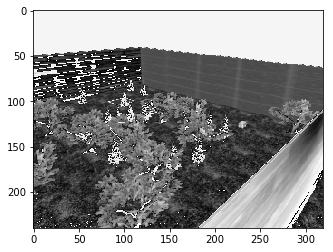

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

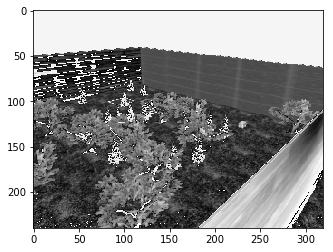

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

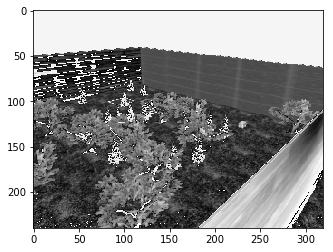

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

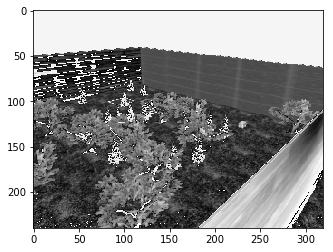

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

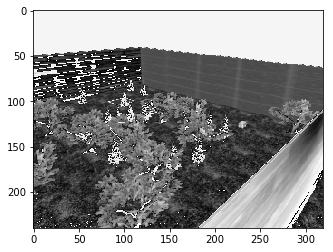

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

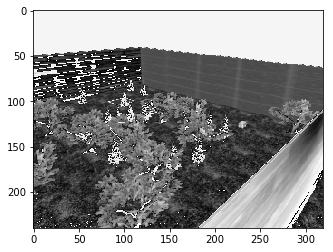

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

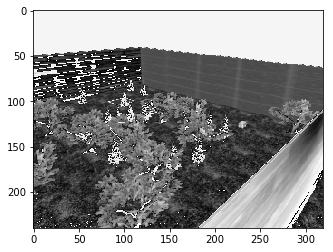

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

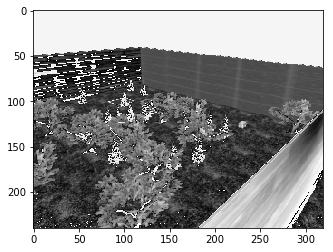

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

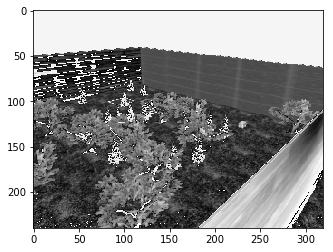

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

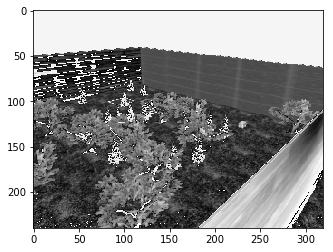

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

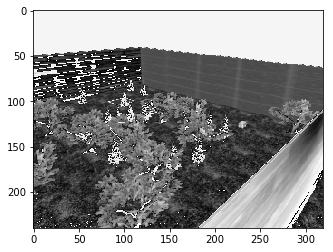

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

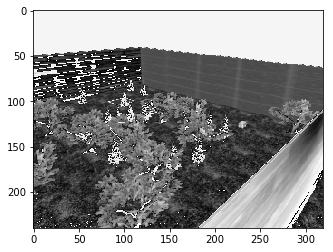

batchpass 0
torch.Size([200, 32805])
batchpass 1
torch.Size([200, 32805])
batchpass 2
torch.Size([200, 32805])
batchpass 3
torch.Size([200, 32805])
batchpass 4
torch.Size([200, 32805])
batchpass 5
torch.Size([200, 32805])
batchpass 6
torch.Size([200, 32805])
batchpass 7
torch.Size([200, 32805])
batchpass 8
torch.Size([200, 32805])
batchpass 9
torch.Size([200, 32805])
batchpass 10
torch.Size([200, 32805])
batchpass 11
torch.Size([200, 32805])
batchpass 12
torch.Size([200, 32805])
batchpass 13
torch.Size([200, 32805])
batchpass 14
torch.Size([200, 32805])
batchpass 15
torch.Size([200, 32805])
batchpass 16
torch.Size([200, 32805])
batchpass 17
torch.Size([200, 32805])
batchpass 18
torch.Size([200, 32805])
batchpass 19
torch.Size([200, 32805])
batchpass 20
torch.Size([200, 32805])
batchpass 21
torch.Size([200, 32805])
batchpass 22
torch.Size([200, 32805])
batchpass 23
torch.Size([200, 32805])
batchpass 24
torch.Size([200, 32805])
batchpass 25
torch.Size([200, 32805])
batchpass 26
torch.Siz

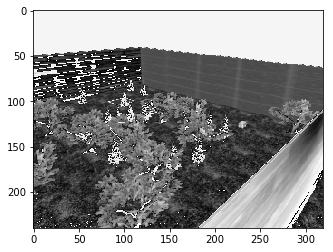

Learning Finished!


In [10]:
print('Learning Started. It takes some time')

for epoch in range(training_epochs):
    avg_cost = 0
    
    readercommand('open')
    
    for i in range(totalBatch):
        batch_xs, batch_ys = getbatch(i)
        print('batchpass',i)
        batch_xs           = batch_xs.to(device) 
        batch_ys           = batch_ys.to(device) 
        
        optimizer.zero_grad()
        hypothesis = model(batch_xs)
        
        cost = criterion(hypothesis, batch_ys)
        cost.backward()
        optimizer.step()
        
        
        avg_cost += cost /totalBatch
    count = 0    
    readercommand('close')    
    print('[Epoch:{}] cost = {}'.format(epoch+1, avg_cost))
    
    with torch.no_grad():
    
        k = copy.copy(batch_xs.to('cpu'))
        k = k.numpy()

        batch_xs           = batch_xs.to(device) 
        print('predic : ',model(batch_xs[1:12,:,:,:]))
        print('Realvl : ',batch_ys[1:12,:])
        plt.imshow(k[1,0,:,:].
                reshape(240, 320 ), cmap='Greys', interpolation='nearest')
        plt.show()
    
    
    
print('Learning Finished!')

1:524396 2:238695 3:216452 4:192203 5:158396 6:88771 7:40054 8:26683 9:18262 10:14678 11:13940 12:13292
13:12504 14:11524 15:11288 16:10775 17:10936 18:10794 19:11834 20:11993 21:12654 22:12216 23:12032
24:10880 25:11340 26:10100 27:10386 28:9960 29:10151 30:10402

torch.Size([11, 32805])
predic :  tensor([[1270.8839, 1480.5221, 1308.4078, 1397.7310],
        [1270.8839, 1480.5221, 1308.4078, 1397.7310],
        [1307.9741, 1522.4529, 1356.7478, 1444.3436],
        [1311.1686, 1526.0829, 1355.3533, 1443.4159],
        [1310.8185, 1525.0485, 1365.9297, 1451.9230],
        [1310.8185, 1525.0485, 1365.9297, 1451.9230],
        [1298.4413, 1515.4438, 1341.0660, 1431.9923],
        [1298.9531, 1515.6466, 1347.0090, 1436.8557],
        [1297.7012, 1515.0117, 1341.9554, 1432.6311],
        [1299.7793, 1517.4774, 1342.0945, 1433.3995],
        [1299.9611, 1517.0878, 1346.5662, 1436.0748]], device='cuda:1')
Realvl :  tensor([[1421., 1530., 1390., 1465.],
        [1421., 1530., 1390., 1465.],
        [1421., 1530., 1390., 1465.],
        [1421., 1530., 1390., 1465.],
        [1421., 1530., 1390., 1465.],
        [1422., 1529., 1390., 1465.],
        [1422., 1529., 1390., 1465.],
        [1421., 1498., 1390., 1465.],
        [1421., 1498., 1390., 1465.],
  

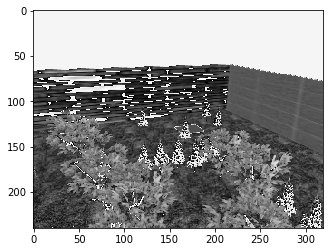

IndexError: index 1 is out of bounds for axis 1 with size 1

In [11]:
with torch.no_grad():
    readercommand('open')
    batch_xs, batch_ys = getbatch(0)
    count = 0 
    k = copy.copy(batch_xs.to('cpu'))
    k = k.numpy()
    
    batch_xs           = batch_xs.to(device) 
    print('predic : ',model(batch_xs[1:12,:,:,:]))
    print('Realvl : ',batch_ys[1:12,:])
    plt.imshow(k[1,0,:,:].
            reshape(240, 320 ), cmap='Greys', interpolation='nearest')
    plt.show()
    plt.imshow(k[1,1,:,:].
            reshape(240, 320 ), cmap='Greys', interpolation='nearest')
    plt.show()
    plt.imshow(k[1,2,:,:].
            reshape(240, 320 ), cmap='Greys', interpolation='nearest')
    plt.show()
    readercommand('close')

In [13]:
torch.save(model.state_dict(), './SAVED/weight_cost:10402_lr:-4_dat:8000_ep:30.pt')

In [ ]:
print('abcde')
print('\b asdf')